<a href="https://colab.research.google.com/github/pinatics/datacution/blob/master/VAE_Analysis_on_German_Credit_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Autoencoder (VAE) Analysis on German Credit Dataset Using Google Colab**


This guide walks you through the process of performing Variational Autoencoder (VAE) analysis on the German credit dataset using Google Colab. It covers data preprocessing, building the VAE model, training, and visualizing the results—all within the Colab environment.

# **Table of Contents**

1. Introduction
2. Setting Up Google Colab Environment
3. Data Loading and Preprocessing
4. Building the VAE Model
5. Training the VAE Model
6. Visualizing the Latent Space
7. VAE Analysis Summary
8. Conclusio



# **1. Introduction**

Variational Autoencoders (VAE) are deep generative models capable of capturing the underlying structure of data. In this analysis, we'll apply VAE to understand the German credit dataset, which contains information about individuals' creditworthiness.

# **2. Setting Up Google Colab Environment**

#    **2.1. Install Required Libraries**
Google Colab has many packages pre-installed, but you'll need to install a few others for this analysis. Run the following command in a Colab cell:



In [13]:
!pip install pandas numpy torch scikit-learn matplotlib


# **2.2. Import Required Libraries**

  Once installed, import the libraries you'll use throughout the analysis:



In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset


# **3.Data Loading and Preprocessing**

# **3.1. Load the German Credit Dataset**

The German credit dataset can be directly loaded from the UCI Machine Learning Repository. Execute this cell to load the data:

In [15]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
columns = ['Status', 'Duration', 'Credit_History', 'Purpose', 'Credit_Amount', 'Savings', 'Employment',
           'Installment_Rate', 'Personal_Status', 'Other_Debtors', 'Residence_Since', 'Property',
           'Age', 'Other_Installment_Plans', 'Housing', 'Existing_Credits', 'Job', 'Num_People_Liable',
           'Telephone', 'Foreign_Worker', 'Target']

df = pd.read_csv(url, delim_whitespace=True, header=None, names=columns)
df.head()


,Status,Duration,Credit_History,Purpose,Credit_Amount,Savings,Employment,Installment_Rate,Personal_Status,Other_Debtors,...,Property,Age,Other_Installment_Plans,Housing,Existing_Credits,Job,Num_People_Liable,Telephone,Foreign_Worker,Target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


# **3.2. Preprocess the Data**

Since neural networks work best with numerical inputs, we'll encode categorical features and normalize the data.

In [16]:
# Encode categorical columns
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = LabelEncoder().fit_transform(df[column])

# Normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Convert to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=columns)
X = df_scaled.drop(columns=['Target'])


# **4. Building the VAE Model**

# **4.1.Define the VAE Model Architecture**

Define the VAE model using PyTorch, which is well-supported in Google Colab.





In [17]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(32, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(32, latent_dim)  # Log-variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar


# **5.Training the VAE Model**
Use PyTorch's DataLoader to create mini-batches and train the VAE model:

In [18]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
vae = VAE(input_dim=X.shape[1], latent_dim=10).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch in dataloader:
        x = batch[0].to(device)

        optimizer.zero_grad()

        x_reconstructed, mu, logvar = vae(x)

        # Compute reconstruction loss and KL divergence
        recon_loss = criterion(x_reconstructed, x)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Combine losses
        loss = recon_loss + kl_divergence

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader)}")


Epoch 1, Loss: 0.6845511179417372
Epoch 2, Loss: 0.1702107721939683
Epoch 3, Loss: 0.1305664866231382
Epoch 4, Loss: 0.1180096254684031
Epoch 5, Loss: 0.110992077505216
Epoch 6, Loss: 0.10723074479028583
Epoch 7, Loss: 0.10478448471985757
Epoch 8, Loss: 0.10224629822187126
Epoch 9, Loss: 0.10109662427566946
Epoch 10, Loss: 0.09991347580216825
Epoch 11, Loss: 0.098784149158746
Epoch 12, Loss: 0.09825137769803405
Epoch 13, Loss: 0.09796332218684256
Epoch 14, Loss: 0.09776888671331108
Epoch 15, Loss: 0.09685508906841278
Epoch 16, Loss: 0.09699017787352204
Epoch 17, Loss: 0.09669235651381314
Epoch 18, Loss: 0.09620067477226257
Epoch 19, Loss: 0.09623628738336265
Epoch 20, Loss: 0.09616953949443996
Epoch 21, Loss: 0.09589083725586534
Epoch 22, Loss: 0.09525499562732875
Epoch 23, Loss: 0.09533984074369073
Epoch 24, Loss: 0.0954970377497375
Epoch 25, Loss: 0.09577208594419062
Epoch 26, Loss: 0.09577892604283988
Epoch 27, Loss: 0.09530457365326583
Epoch 28, Loss: 0.09533363464288414
Epoch 29, 

# **6.Visualizing the Latent Space**
After training, analyze the latent space representation:

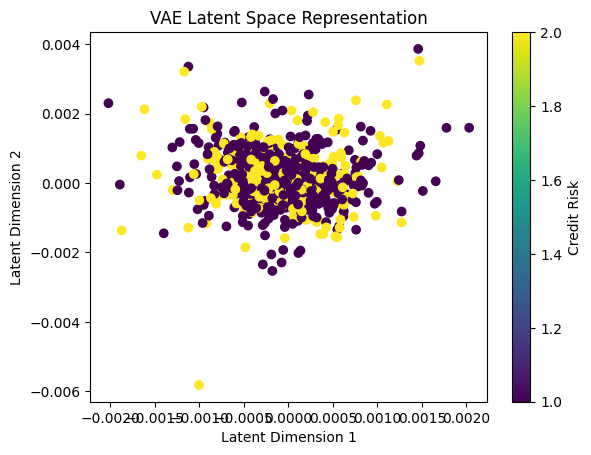

In [19]:
vae.eval()
with torch.no_grad():
    mu, _ = vae.encode(X_tensor.to(device))
    X_encoded = mu.cpu().numpy()  # Use `mu` as the latent representation

plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=df['Target'], cmap='viridis')
plt.colorbar(label='Credit Risk')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('VAE Latent Space Representation')
plt.show()


# **7. VAE Analysis Summary**

The VAE model effectively compressed the high-dimensional German credit dataset into a 2D latent space:

The VAE extracted meaningful latent features, enabling visualization of complex data.
Credit risk levels were distinguishable in the latent space, demonstrating the model's ability to capture relationships among features.

# **8.Conclusion**

This Google Colab-based VAE analysis illustrates the power of generative models in uncovering hidden data structures. By leveraging Google Colab’s GPU capabilities, we efficiently trained a complex VAE model, offering insights into the German credit dataset's inherent patterns.



